In [28]:
from __future__ import division
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import tensorflow as tf


In [29]:
""" Reading data"""

data_x = np.load('ex5_train_x.npy', mmap_mode='r')
data_y = np.load('ex5_train_y.npy', mmap_mode='r')

"""normalising data_x"""
data_x1 = (data_x / 255) - 0.5
#print(data_y.shape)
data_y1 = data_y.reshape(1020,1)
#print(data_y1.shape)


In [30]:
def zero_padding(data, padding):
    m = len(data)
    data_padded = np.zeros((data.shape[0], data.shape[1]+2, data.shape[2]+2, data.shape[3]))
    for i in range(m):
        data_T = data[i].T
        data_temp = np.zeros((data_T.shape[0], data_T.shape[1]+2, data_T.shape[2]+2))
        for j in range(0, len(data_T)):
            temp = np.pad(data_T[j], (padding, padding), 'constant', constant_values=(0))
            data_temp[j] = temp
        data_padded[i] = data_temp.T
    return data_padded
            
    

In [31]:
def conv_forward(padding, stride, data, filter_size, filters, bias):
    
    m = len(data)
    image_size = data.shape[1]
    filters_number = filters.shape[3]
    if(padding > 0):
        data_aftr_pad = zero_padding(data_x1, padding)
    else:
        data_aftr_pad = data
        
    output_size = ((image_size + 2*padding - filter_size) / stride) + 1
    #output_size = ((image_size - filter_size) / stride) + 1
    #print("this is output size %s " %output_size)
    output = np.zeros((m, int(output_size), int(output_size), filters_number)) 
    n_h = output.shape[1]
    n_w = output.shape[2]
    n_ch = output.shape[3]
    for i in range(m):
        #data_each = data[i, :]
        data_each = data_aftr_pad[i, :]
        for h in range(n_h):
            vert_start = h * stride
            vert_end = h * stride + filter_size
            if(vert_end > data_each.shape[0]):
                break
            for w in range(n_w):
                horiz_start = w * stride
                horiz_end = w * stride + filter_size
                if(horiz_end > data_each.shape[1]):
                    break
                for c in range(n_ch):
                    a_slice = data_each[vert_start:vert_end, horiz_start:horiz_end, :]
                    #print(a_slice)
                    output[i, h, w, c] = conv_single_step1(a_slice, filters[:, :, :, c], bias[:, :, :, c])
    #print("endtime %s")
    #print(time.time())
    cache = (data, filters, bias, padding, stride)
    return output, cache      
        
    

In [32]:
def conv_single_step1(a_slice_prev, W, bias):
   
    sum = np.multiply(a_slice_prev, W) + bias
    Z = np.sum(sum)
    
    return Z

In [33]:
"""pooling - mode is either 'max' or 'avg' """

def pool_forward(padding, stride, data, filter_size, mode):
    m = len(data)
    image_size = data.shape[1]
    filters_number = data.shape[3]
    output_size = ((image_size + 2 * padding - filter_size) / stride) + 1
    output = np.zeros((m, int(output_size), int(output_size), filters_number)) 
    n_h = output.shape[1]
    n_w = output.shape[2]
    n_ch = output.shape[3]
    for i in range(m):
        for h in range(n_h):
            vert_start = h * stride
            vert_end = h * stride + filter_size
            if(vert_end > data.shape[1]):
                break
            for w in range(n_w):
                horiz_start = w * stride
                horiz_end = w * stride + filter_size
                if(horiz_end > data.shape[2]):
                    break
                for c in range(n_ch):
                    a_slice = data[i,vert_start:vert_end, horiz_start:horiz_end, c]
                    if (mode == 'max'):
                        output[i, h, w, c] = np.max(a_slice)
                    elif (mode == 'avg'):
                        output[i, h, w, c] = np.mean(a_slice)
    cache = (data, stride, padding, filter_size)
    return output, cache                    
                        

In [34]:
"""ReLU activation"""

def relu_activation(data_array):
    return np.maximum(data_array, 0)

In [35]:
def dRelu(data_array):
    data_array[data_array<=0] = 0
    data_array[data_array>0] = 1
    return data_array

In [36]:
"""Function for One hot encoding. input Y as an array and no.of samples is passed to the function"""

def One_Hot_Encoding(arr, samples_num):
    encode_matrix = np.zeros((samples_num, 6))
    for i in range(samples_num):
        encode_matrix[i][arr[i][0]] = 1
    return encode_matrix

In [37]:
Y_en = One_Hot_Encoding(data_y1, len(data_y1))

In [38]:
def forwardpropagation(W1, W2, A, b1, b2):
    
    """ performing forward propagation. returns new neurons and Zs"""

    part1 = np.dot(A, W1.T)      #
    Z1 = np.add(part1.T,b1)     #
    #A1 = sigmoid(Z1)            #
    A1 = relu_activation(Z1)
    
    part2 = np.dot(W2,A1) 
    Z2 = np.add(part2,b2)       #
    A2 = sigmoid(Z2)           # 
    A2 = A2.T                   #

     
    return A1, A2, Z1, Z2
         

In [39]:
def sigmoid(z):
    
    """ sigmoid function when an array is passed as parameter"""
    
    return 1/(1 + np.exp(-z))   

In [40]:
def dSigmoid(A):
    
    "derivative of sigmoid function or sigmoid prime"

    return np.multiply(A, (1 - A))

In [41]:

def backwardpropagation(A1, A2, Z1, Y, X):
    
    """ backward propagation function. the function ouputs gradient of weights and bias"""
    
    m = len(A1)
    dZ2 = A2 - Y   #
    #print(dZ2.shape)
    dW2 = (1/m) * np.dot(dZ2.T, A1.T) #
    db2 = (1/m) * np.sum(dZ2.T, axis=1, keepdims = True) 
    #gdashZ1 = dSigmoid(A1)  #
    gdashZ1 = dRelu(A1)
    dZ1_firstpart = np.dot(dZ2, W2) # 
    dZ1 = np.multiply(dZ1_firstpart.T, gdashZ1) # 
    dW1 = (1/m) * np.dot(dZ1, X) # 
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims = True) 
    dA0 = np.dot(dZ1.T, W1)
        
    return dW1, dW2, db1, db2, dA0

In [42]:
def gradientDescent(dW1, dW2, db1, db2, B1, B2, W1, W2, alpha):
    
    
    """ gradient descent calcualtes new weights and bais"""

    
    w2 = W2 - alpha * dW2
    w1 = W1 - alpha * dW1
    b1 = B1 - alpha * db1
    b2 = B2 - alpha * db2
    
    return w1, w2, b1, b2 

In [43]:
def lossFunction(y_en, final_A1):
    
    """ calculating loss functions - y (is given data Y) and y1(is A2) are arrays """
    import math
    m = len(final_A1)
    final_A = np.clip(final_A1, 0.0001, 0.99999)
    loss = (-1/m) * np.sum(np.multiply(y_en, np.log(final_A)) + np.multiply(1 - y_en, np.log(1 - final_A)))
    
    return loss

In [44]:
def softmax(x):
    
    """ softmax function final A2 is passed as parameter (e power x) / sum(e power x)"""
    E = np.exp(x)
    deno =  np.sum(np.exp(x), axis=1, keepdims=True)
    deno = deno.reshape(deno.shape[0],1)
    probs = E / deno
    return probs

In [45]:
def pool_backward(dFA0, cache_pool, mode):
    
    """ cache_pool output from pooling forward"""
    """ dP is output of first layer fully connected NN during back propagation """
    
    data_prev, stride, padding, filter_size = cache_pool
    m, n_h_prev, n_w_prev, n_ch_prev = data_prev.shape
    m, n_h, n_w, n_ch = dFA0.shape
    dA = np.zeros(data_prev.shape)
    
    for i in range(m):
        data_each = data_prev[i]
        for h in range(n_h):
            vert_start = h * stride
            vert_end = h * stride + filter_size
            if(vert_end > data_prev.shape[1]):
                break
            for w in range(n_w):
                horiz_start = w * stride
                horiz_end = w * stride + filter_size
                if(horiz_end > data_prev.shape[2]):
                    break
                for c in range(n_ch):
                    if(mode == 'max'):
                        a_slice = data_each[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = a_slice == np.max(a_slice)
                        dA[i, vert_start:vert_end, horiz_start:horiz_end, c ] += np.multiply(mask , dFA0[i, h, w, c])
                    
                        
    return dA                    
    

In [46]:
def conv_backward(data_poolback, con_frwd_data, learning_rate):
    
    """data_poolback is output from pooling layer during back propagation. ouput of pool_backward function"""
    """con_frwd_data is output of conv_forward function for this layer. this is stored as cache in conv_forward function"""
    """ this function return the ouput of conv_backward operation which is a numpy array and updated weight and bias"""
    
    data_prev, filters, bias, padding, stride = con_frwd_data
    m, n_h, n_w, n_ch = data_poolback.shape #shape of ouput od poolbackward
    #print(data_poolback.shape)
    m, n_h_prev, n_w_prev, n_ch_prev= data_prev.shape
    filter_size = filters.shape[0]
    #filters_T = filters.T
    dA_prev = np.zeros((m, n_h_prev, n_w_prev, n_ch_prev))
    dW = np.zeros(filters.shape)
    #print("shape od dw")
    #print(dW.shape)
    db = np.zeros(bias.shape)
    if (padding > 0):
        """if padding present during convolution_forward, same padding for backward"""
        data_prev_pad = zero_padding(data_prev, padding)
        dA_prev_pad = zero_padding(dA_prev, padding)
    else:
        data_prev_pad = data_prev #padding = 0, copy the same data array
        dA_prev_pad = dA_prev
        
    """loop on the dimensions of pool backward output and loop on data of convolution forward input"""
    for i in range(m):
        data_prev_pad_each =  data_prev_pad[i]
        dA_prev_pad_each = dA_prev_pad[i]
        for h in range(n_h):
            vert_start = h * stride
            vert_end = h * stride + filter_size
            if(vert_end > data_prev_pad.shape[1]):
                break
            for w in range(n_w):
                horiz_start = w * stride
                horiz_end = w * stride + filter_size
                if(horiz_end > data_prev_pad.shape[2]):
                    break
            for c in range(n_ch):
                a_slice = data_prev_pad_each[vert_start:vert_end, horiz_start:horiz_end, :]
                #print(data_poolback[i, h, w, c].shape)
                dA_prev_pad_each[vert_start:vert_end, horiz_start:horiz_end, :] += filters[:,:,:,c] * data_poolback[i, h, w, c]
                dW[:,:,:,c] += a_slice * data_poolback[i, h, w, c]
                db[:,:,:,c] += data_poolback[i, h, w, c]
        if(padding > 0):
            dA_prev[i, :, :, :] = dA_prev_pad_each[padding:-padding, padding:-padding, :]
        else:
            dA_prev[i, :, :, :] = dA_prev_pad_each
            
    """calculating new weights and bias"""
    new_W = filters - learning_rate * dW
    new_bias = bias - learning_rate * db
    
    return dA_prev, new_W, new_bias  
    
    

In [47]:
"""loading weights and biases from file"""
import h5py
dataset = h5py.File("weights_rma.hdf5", "r")

W1 = np.array(dataset["W1"])
W2 = np.array(dataset["W2"])
B1 = np.array(dataset["B1"])
B2 = np.array(dataset["B2"])
filter_set1 = np.array(dataset["filter_set1"])
filter_set2 = np.array(dataset["filter_set2"])
conv_bias1 = np.array(dataset["conv_bias1"])
conv_bias2 = np.array(dataset["conv_bias2"])


In [51]:
def model_final(W1, W2, filter_set1, filter_set2, conv_bias1, conv_bias2, B1, B2):
    for i in range (2):
    
        conv1_data, cache_conv1 = conv_forward(1, 2, data_x1, 4, filter_set1, conv_bias1) # conv_forward of CNN layer 1
        conv1_data_relu = relu_activation(conv1_data)
        pool1_data, cache_pool1 = pool_forward(0, 1, conv1_data_relu, 5, 'max') # pool_forward for CNN layer 1
        conv2_data, cache_conv2 = conv_forward(0, 2, pool1_data, 4, filter_set2, conv_bias2) #conv_forward of CNN layer 2
        conv2_data_relu = relu_activation(conv2_data)
        pool2_data, cache_pool2 = pool_forward(0, 1, conv2_data_relu, 5, 'max') # pool_forward for CNN layer 2

        samples = pool2_data.shape[0]
        flatten_size = pool2_data.shape[1] * pool2_data.shape[2] * pool2_data.shape[3] #flattening data
        flatten_data = pool2_data.reshape(samples, flatten_size )

        A1, A2, Z1, Z2 = forwardpropagation(W1, W2, flatten_data, B1, B2) #forward propagation in fully connected layers

        dW1, dW2, db1, db2, dA0 = backwardpropagation(A1, A2, Z1, Y_en, flatten_data) #backward propagation in fully connected

        W1, W2, B1, B2 = gradientDescent(dW1, dW2, db1, db2, B1, B2, W1, W2, 0.001)

        dA0_unflatten = dA0.reshape(pool2_data.shape) #unflatting the ouput of fully connected back prop
        dA_pool2 = pool_backward(dA0_unflatten, cache_pool2, 'max') #pool_backward in CNN layer 2
        dA_relu_backward2 = dRelu(dA_pool2) #relu activation backward

        dA_cnn2, filter_set2, conv_bias2 = conv_backward(dA_relu_backward2, cache_conv2, 0.001) #conv_backward CNN layer 2

        dA_pool1 = pool_backward(dA_cnn2, cache_pool1, 'max') #pool_backward in CNN layer 1
        dA_relu_backward1 = dRelu(dA_pool1) # relu activation backward

        dA_cnn1, filter_set1, conv_bias1 = conv_backward(dA_relu_backward1, cache_conv1, 0.001) #conv_backward CNN layer 1
        
    return conv1_data, conv2_data, pool1_data, pool2_data, flatten_data, A1, A2


In [52]:
conv1_data, conv2_data, pool1_data, pool2_data, flatten_data, A1, A2 = model_final(W1, W2, filter_set1, filter_set2, conv_bias1, conv_bias2, B1, B2)

In [53]:
"""printing dimensions of each layer"""

print("Input data Shape is ")
print(data_x1.shape)
print("C1 - Convlution Layer 1 Shape is ")
print(conv1_data.shape)
print("P1 - Pool Layer 1 Shape is ")
print(pool1_data.shape)
print("C2 - Convlution Layer 2 Shape is ")
print(conv2_data.shape)
print("P2 - Pool Layer 2 Shape is ")
print(pool2_data.shape)
print("F3 - Input to fully connected layer Shape is ")
print(flatten_data.shape)
print("F4 - Hidden layer - A1 - Shape")
print(A1.shape)
print("F5 - Output layer Shape - A2- Shape ")
print(A2.shape)


Input data Shape is 
(1020, 64, 64, 3)
C1 - Convlution Layer 1 Shape is 
(1020, 32, 32, 8)
P1 - Pool Layer 1 Shape is 
(1020, 28, 28, 8)
C2 - Convlution Layer 2 Shape is 
(1020, 13, 13, 16)
P2 - Pool Layer 2 Shape is 
(1020, 9, 9, 16)
F3 - Input to fully connected layer Shape is 
(1020, 1296)
F4 - Hidden layer - A1 - Shape
(108, 1020)
F5 - Output layer Shape - A2- Shape 
(1020, 6)


In [54]:
"""loss of the model trained """
loss = lossFunction(Y_en, A2)
print("cost of the model is %s " %loss)

cost of the model is 2.705206385239963 


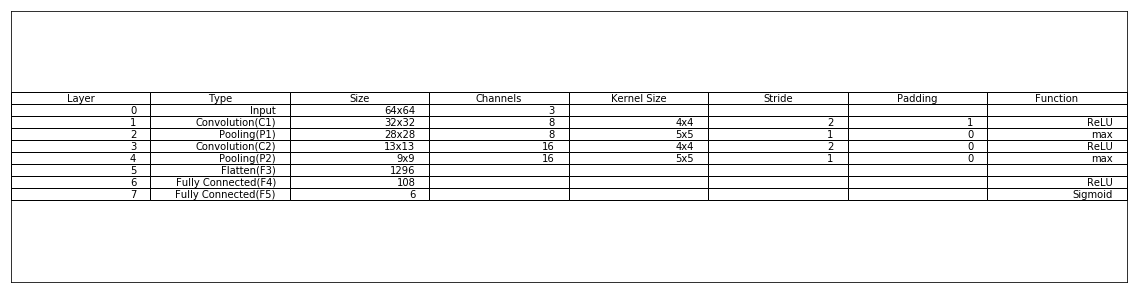

In [55]:
"""architecture -tabular representation"""

fig, ax = plt.subplots(figsize=(20, 5))

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)


data = [['0', 'Input', '64x64', '3', '', '', '', ''], ['1', 'Convolution(C1)', '32x32', '8', '4x4', '2', '1', 'ReLU'],
           ['2', 'Pooling(P1)', '28x28', '8', '5x5', '1', '0', 'max'],
           ['3', 'Convolution(C2)', '13x13', '16', '4x4', '2', '0', 'ReLU'],
           ['4', 'Pooling(P2)', '9x9', '16', '5x5', '1', '0', 'max'],
           ['5', 'Flatten(F3)', '1296', '', '', '', '', ''],
           ['6', 'Fully Connected(F4)', '108', '', '', '', '', 'ReLU' ],
           ['7', 'Fully Connected(F5)', '6', '', '', '', '', 'Sigmoid']
          ]
collabel=("Layer", "Type", "Size", "Channels", "Kernel Size", "Stride", "Padding", "Function" )
ax.table(cellText=data,colLabels=collabel,loc='center')